In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=986841a252bc6195657c5441ea9a4f6b9c4469b62497f34afa48d688b42e8fb8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession


from pyspark.sql.functions import *

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()

In [3]:
spark

In [4]:
df = spark.read.options(header=True).csv('/content/touring_dataset.csv')

In [5]:
df.show()

+---+--------------------+--------------------+--------------------+--------------------+----+------------+--------------+-----------------+-----------+---------+-------------+-----+-------+---------------+-----------+-----------+-------+---------------+----+-----+--------------------+--------------------+----------+----------+----------+----------+----------+----------+-----------+------------+-------------+----------------+--------------+--------+--------------------+
|_c0|               appId|           developer|         developerId|    developerWebsite|free|       genre|       genreId|inAppProductPrice|minInstalls|offersIAP|originalPrice|price|ratings|len screenshots|adSupported|containsAds|reviews|releasedDayYear|sale|score|             summary|               title|   updated|histogram1|histogram2|histogram3|histogram4|histogram5|releasedDay|releasedYear|releasedMonth|     dateUpdated|      minprice|maxprice|ParseReleasedDayYear|
+---+--------------------+--------------------+---

In [ ]:
import networkx as nx
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext

# df = spark.read.option('header', True).csv("/content/LP_SAMPLE_DATA.csv")
df = spark.read.option('header', True).csv("/content/lp_sample_session_data_v2.csv")
# df.show()
df = df.filter(~F.col('msg_WebContext_Page_Referrer').isin(['null']))

# filter the new users
new_users_df = df.filter(F.col('return') == 'null')
new_users_df.show()

+--------------------------+------------------------+--------------------+---------------+-------------------------+--------------------+-----------------------+--------------------------+--------------------+----------------------+-----------------------+------------------------+--------------------+--------------------------+-----------------------+----------------------------+---------------------+----------------------+----------------------------------+------------------------+-------------------------------------+-----------------------------+------------------------------------+----------------------------------------+--------------------------------------+----------------------------+----------------------------------+--------------------------------------+-----------------------------+-----------------------------------+---------------------------------+---------------------------------------+------------------------------+------------------------------+----------------+------

+--------------------------+------------------------+--------------------+---------------+-------------------------+--------------------+-----------------------+--------------------------+--------------------+----------------------+-----------------------+------------------------+--------------------+--------------------------+-----------------------+----------------------------+---------------------+----------------------+----------------------------------+------------------------+-------------------------------------+-----------------------------+------------------------------------+----------------------------------------+--------------------------------------+----------------------------+----------------------------------+--------------------------------------+-----------------------------+-----------------------------------+---------------------------------+---------------------------------------+------------------------------+------------------------------+----------------+------

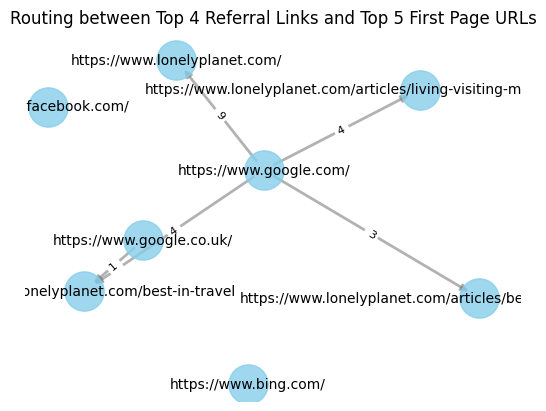

In [ ]:
import networkx as nx
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext

df = spark.read.option('header', True).csv("/content/LP_SAMPLE_DATA.csv")
df.show()
df = df.filter(~F.col('msg_WebContext_Page_Referrer').isin(['null']))

# filter the new users
new_users_df = df.filter(F.col('return') == 'new')

# group by referral link and first page URL and count the number of new users for each pair
new_users_df.show()
referral_firstpage_counts_df = new_users_df.groupBy('msg_WebContext_Page_Referrer', 'msg_WebContext_Page_Url').agg(F.count('msg_WebContext_AnonymousId').alias('new_user_count'))


top_referrals_df = referral_firstpage_counts_df.groupBy('msg_WebContext_Page_Referrer').agg(F.sum('new_user_count').alias('new_user_count')).orderBy(F.col('new_user_count').desc()).limit(4)

top_firstpages_df = referral_firstpage_counts_df.groupBy('msg_WebContext_Page_Url').agg(F.sum('new_user_count').alias('new_user_count')).orderBy(F.col('new_user_count').desc()).limit(5)
referral_firstpage_counts_df = referral_firstpage_counts_df.filter(F.col('msg_WebContext_Page_Url').isin([r['msg_WebContext_Page_Url'] for r in top_firstpages_df.collect()]))

top_firstpages_df.show()
# create a graph and add nodes and edges
G = nx.DiGraph()
for row in top_referrals_df.collect():
    G.add_node(row['msg_WebContext_Page_Referrer'])
for row in referral_firstpage_counts_df.collect():
    if row['msg_WebContext_Page_Referrer'] in [r['msg_WebContext_Page_Referrer'] for r in top_referrals_df.collect()] and row['msg_WebContext_Page_Url'] in [r['msg_WebContext_Page_Url'] for r in top_firstpages_df.collect()]:
        G.add_edge(row['msg_WebContext_Page_Referrer'], row['msg_WebContext_Page_Url'], weight=row['new_user_count'])

# draw the graph
pos = nx.spring_layout(G)
edge_labels = {(u, v): str(d['weight']) for u, v, d in G.edges(data=True)}
nx.draw_networkx_nodes(G, pos, node_size=800, alpha=0.8, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='Arial')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_family='Arial')
plt.title('Routing between Top 4 Referral Links and Top 5 First Page URLs')


# pos = nx.multipartite_layout(G, subset_key='layer')
# edge_labels = {(u, v): str(d['weight']) for u, v, d in G.edges(data=True)}
# nx.draw_networkx_nodes(G, pos, node_size=800, alpha=0.8, node_color='skyblue')
# nx.draw_networkx_labels(G, pos, font_size=10, font_family='Arial')
# nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_family='Arial')
# plt.title('Routing between Top 4 Referral Links and Top 5 First Page URLs')

plt.axis('off')
plt.show()



+----------------------------+--------------+
|msg_WebContext_Page_Referrer|new_user_count|
+----------------------------+--------------+
|        https://www.googl...|           524|
|        https://www.bing....|            43|
|        http://m.facebook...|            39|
|        https://www.googl...|            34|
+----------------------------+--------------+



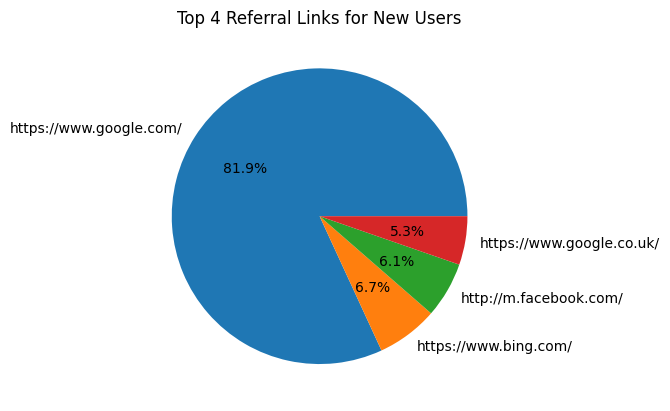

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext

df = spark.read.option('header', True).csv("/content/LP_SAMPLE_DATA.csv")

df = df.filter(~F.col('msg_WebContext_Page_Referrer').isin(['null']))

# filtering the fresh users
new_users_df = df.filter(F.col('return') == 'new')

# group by referral link and count the number of fresh users for each link
referral_counts_df = new_users_df.groupBy('msg_WebContext_Page_Referrer').agg(F.count('msg_WebContext_AnonymousId').alias('new_user_count'))

# Top 4 Referrals
top_referrals_df = referral_counts_df.orderBy(F.col('new_user_count').desc()).limit(4)
top_referrals_df.show()

data = top_referrals_df.collect()
plt.pie([row['new_user_count'] for row in data], labels=[row['msg_WebContext_Page_Referrer'] for row in data], autopct='%1.1f%%')
plt.title('Top 4 Referral Links for New Users')
plt.show()
